In [15]:
#Ex 1
class Romberg:
    def __init__(self,f,a,b):
        self.f = f
        self.a = a
        self.b = b
        self.p = 0
        self.N = 1
        self.S = 0.5*(f(a)+f(b))
        self.h = (b-a)
        self.I = self.S*self.h
        self.I_last = self.I
        self.n_eval = 0
    def iteration(self):
        self.n_eval += self.N
        x = self.a+self.h*0.5
        somme = self.f(x)
        for k in range(self.N-1):
            x += self.h
            somme += f(x)
        self.N *= 2
        self.p += 1
        self.S += somme
        self.h *= 0.5
        self.I_last = self.I
        self.I = self.h*self.S
        
    def iterations(self,P):
        I = [self.I]
        h = [self.h]
        while self.p<P:
            self.iteration()
            I.append(self.I)
            h.append(self.h)
        return (numpy.array(h),numpy.array(I))
        
    def trapezes(self,epsilon):
        I = [self.I]
        h = [self.h]
        self.iteration()
        while abs(self.I-self.I_last)>epsilon:
            self.iteration()
            I.append(self.I)
            h.append(self.h)
        return (numpy.array(h),numpy.array(I))
        
    def romberg(self,epsilon):
        jmax = 20
        A=numpy.zeros((jmax+1,jmax+1))
        A[0][0] = self.I
        self.iteration()
        A[1][0] = self.I
        correction = (A[1][0]-A[0][0])/3
        A[1][1] = A[1][0] + correction
        j = 2
        while abs(correction) > epsilon:
            self.iteration()
            A[j][0] = self.I
            for i in range(1,j+1):
                correction = (A[j][i-1]-A[j-1][i-1])/(4**i-1)
                A[j][i] = A[j][i-1] + correction
            j += 1
        return (A[0:j-1,0:j-1],A[j-1][j-1])

In [16]:
import numpy
def f(x):
    return x**5
romberg = Romberg(f,0,1)
(h,I) = romberg.trapezes(1e-7)

In [17]:
print(I[-1]-1.0/6)

2.4835268314093994e-08


In [18]:
print(romberg.n_eval)

4095


In [26]:
#Ex 2

import numpy as N

import matplotlib.pyplot as P



import pytest                    # pytest importe pour les tests unitaires





class Simulation:



    def __init__(self, temp, dens, path):

        self.temp = float(temp)

        self.dens = float(dens)

        tmp = N.loadtxt(path, skiprows=1).T

        self.pot = tmp[0]

        self.kin = tmp[1]

        self.tot = self.pot + self.kin

        self.press = tmp[2]



    def __str__(self):

        return "Simulation at {:.0f} g/cc and {:.0f} K ; {:d} timesteps". \

            format(self.dens, self.temp, len(self.pot))



    def thermo(self, skipSteps=0):

        return {'T': self.temp,

                'rho': self.dens,

                'E': self.tot[skipSteps:].mean(),

                'P': self.press[skipSteps:].mean(),

                'dE': self.tot[skipSteps:].std(),

                'dP': self.press[skipSteps:].std()}



    def plot(self, skipSteps=0):

        fig, (axen, axpress) = P.subplots(2, sharex=True)

        axen.plot(list(range(skipSteps, len(self.tot))), self.tot[skipSteps:],

                  'rd--')

        axen.set_title("Internal energy (Ha)")

        axpress.plot(list(range(skipSteps, len(self.press))), self.press[skipSteps:],

                     'rd--')

        axpress.set_title("Pressure (GPa)")

        axpress.set_xlabel("Timesteps")



        P.show()



##### Tests pour Simulation #####





def mimic_simulation(filename):

    with open(filename, 'w') as f:

        f.write("""Potential energy (Ha)	Kinetic Energy (Ha)	Pressure (GPa)

-668.2463567264        	0.7755612311   		9287.7370229824

-668.2118514558        	0.7755612311		9286.1395903265

-668.3119088218        	0.7755612311		9247.6604398856

-668.4762735176        	0.7755612311		9191.8574820856

-668.4762735176        	0.7755612311		9191.8574820856

""")





def test_Simulation_init():

    mimic_simulation("equationEtat_simuTest.out")

    s = Simulation(10, 10, "equationEtat_simuTest.out")

    assert len(s.kin) == 5

    assert abs(s.kin[2] - 0.7755612311) < tolerance

    assert abs(s.pot[1] + 668.2118514558) < tolerance





def test_Simulation_str():

    mimic_simulation("equationEtat_simuTest.out")

    s = Simulation(10, 20, "equationEtat_simuTest.out")

    assert str(s) == "Simulation at 20 g/cc and 10 K ; 5 timesteps"





def test_Simulation_thermo():

    mimic_simulation("equationEtat_simuTest.out")

    s = Simulation(10, 20, "equationEtat_simuTest.out")

    assert abs(s.thermo()['T'] - 10) < tolerance

    assert abs(s.thermo()['rho'] - 20) < tolerance

    assert abs(s.thermo()['E'] + 667.56897157674) < tolerance

    assert abs(s.thermo()['P'] - 9241.0504034731) < tolerance

    assert abs(s.thermo(3)['E'] + 667.7007122865) < tolerance

    assert abs(s.thermo(3)['P'] - 9191.8574820856) < tolerance



###################

### Main script ###

###################



if __name__ == '__main__':

    ### Definitions ###

    a0 = 0.52918      # Bohr radius in angstrom

    amu = 1.6605      # atomic mass unit in e-24 g

    k_B = 3.16681e-6  # Boltzmann's constant in Ha/K

    # normalization factor for P/nkT

    nk_GPa = a0 ** 3 * k_B * 2.942e4 / 6 / amu

    nsteps = 200  # define skipped timesteps (should be done for

    # each simulation...)

    temps = [6000, 20000, 50000]    # define temperatures

    colors = {6000: 'r', 20000: 'b', 50000: 'k'}

    denss = [7, 15, 25, 30]  # define densities

    keys = ['T', 'rho', 'E', 'dE', 'P', 'dP']

    eos = dict.fromkeys(keys, N.zeros(0))   # {key:[]}



    ### Extract the EOS out of the source files ###

    for t, rho in [(t, rho) for t in temps for rho in denss]:

        filenm = "outputs/{}K_{:0>2d}gcc.out".format(t, rho)

        s = Simulation(t, rho, filenm)

        for key in keys:

            eos[key] = N.append(eos[key], s.thermo(nsteps)[key])



    ### Plot isotherms ###

    fig, (axen, axpress) = P.subplots(2, sharex=True)

    fig.suptitle("High-pressure equation of state for water", size='x-large')

    axen.set_title("Energy")

    axen.set_ylabel("U / NkT")

    axpress.set_title("Pressure")

    axpress.set_ylabel("P / nkT")

    axpress.set_xlabel("rho (g/cc)")

    for t in temps:

        sel = eos['T'] == t

        axen.errorbar(x=eos['rho'][sel], y=eos['E'][sel] / k_B / t,

                      yerr=eos['dE'][sel] / k_B / t, fmt=colors[t] + '-')

        axpress.errorbar(x=eos['rho'][sel],

                         y=eos['P'][sel] / eos['rho'][sel] / nk_GPa / t,

                         yerr=eos['dP'][sel] / eos['rho'][sel] / nk_GPa / t,

                         fmt=colors[t] + '-',

                         label="{} K".format(t))

    axpress.legend(loc='best')

    P.show()



SyntaxError: invalid syntax (<ipython-input-26-1eb5c3c616dc>, line 40)

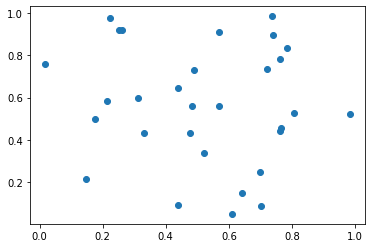

In [19]:
#Ex 3
import random
n = 30
x = [ random.random() for _ in range(n) ]
y = [ random.random() for _ in range(n) ]
import matplotlib.pyplot as plt
plt.plot(x,y,"o")

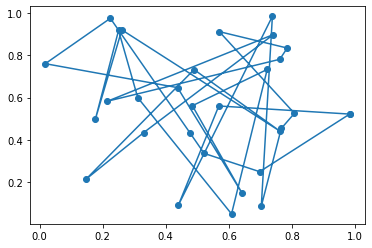

In [20]:
plt.plot(x + [ x[0] ], y + [ y[0] ], "o-")

longueur initiale 7.469874018031982
iteration 2 d= 7.469874018031982
iteration 3 d= 1.1643863406845703
iteration 4 d= 0.9570928149234498
longueur min 0.9570928149234498


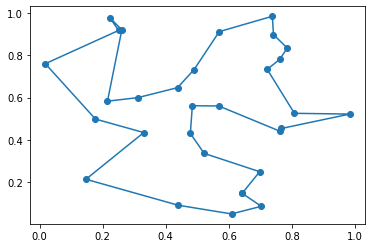

In [21]:
def longueur (x,y, ordre):
    i = ordre[-1]
    x0,y0 = x[i], y[i]
    d = 0
    for o in ordre:
        x1,y1 = x[o], y[o]
        d += (x0-x1)**2 + (y0-y1)**2
        x0,y0 = x1,y1
    return d

ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

def permutation(x,y,ordre):
    d  = longueur(x,y,ordre)
    d0 = d+1
    it = 1
    while d < d0 :
        it += 1
        print("iteration",it, "d=",d)
        d0 = d
        for i in range(0,len(ordre)-1) :
            for j in range(i+2,len(ordre)):
                r = ordre[i:j].copy()
                r.reverse()
                ordre2 = ordre[:i] + r + ordre[j:]
                t = longueur(x,y,ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

ordre = permutation (x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")

longueur initiale 7.314404551022376
iteration 2 d= 7.314404551022376
iteration 3 d= 1.0996002824695161
iteration 4 d= 0.9117777320406354
iteration 5 d= 0.9108713053485415
longueur min 0.9108713053485415


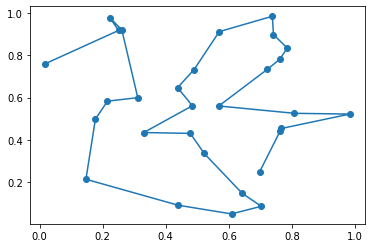

In [24]:
#Supposons une erreur de calcul à savoir nous oublions le dernier arc qui boucle le chemin du dernier noeud au premier
def longueur (x,y, ordre):
    # on change cette fonction
    d = 0
    for i in range(1,len(ordre)):
        n = ordre[i-1]
        o = ordre[i]
        x0,y0 = x[n], y[n]
        x1,y1 = x[o], y[o]
        d += (x0-x1)**2 + (y0-y1)**2
    return d

ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

ordre = permutation (x,y,list(range(len(x))))
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre]
yo = [ y[o] for o in ordre]
plt.plot(xo,yo, "o-")
#C'est toujours bien le chemin le plus court

longueur initiale 7.314404551022376
iteration 0 d= 7.314404551022376
iteration 1 d= 0.8994797390988534
iteration 2 d= 0.8564190596458632
iteration 3 d= 0.8564190596458632
iteration 4 d= 0.8564190596458632
iteration 5 d= 0.8564190596458632
iteration 6 d= 0.8564190596458632
iteration 7 d= 0.8217631939741296
iteration 8 d= 0.8134879763825056
iteration 9 d= 0.8134879763825056
iteration 10 d= 0.8134879763825056
iteration 11 d= 0.8134879763825056
iteration 12 d= 0.8134879763825056
iteration 13 d= 0.8134879763825056
iteration 14 d= 0.8134879763825056
iteration 15 d= 0.8134879763825056
iteration 16 d= 0.8134879763825056
iteration 17 d= 0.8122819231357673
iteration 18 d= 0.8122819231357673
iteration 19 d= 0.8122819231357673
longueur min 0.8122819231357673


Text(0.9830671028256462, 0.5221003640655848, 'N-1')

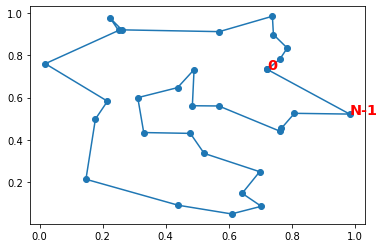

In [25]:
#Programme final ajustant la précision et les chemins tout en évitant les croisements
ordre = list(range(len(x)))
print("longueur initiale", longueur(x,y,ordre))

def permutation_rnd(x,y,ordre,miniter):
    d  = longueur(x,y,ordre)
    d0 = d+1
    it = 1
    while d < d0 or it < miniter :
        it += 1
        d0 = d
        for i in range(1,len(ordre)-1) :
            for j in range(i+2,len(ordre)+ 1):
                k = random.randint(1,len(ordre)-1)
                l = random.randint(k+1,len(ordre))
                r = ordre[k:l].copy()
                r.reverse()
                ordre2 = ordre[:k] + r + ordre[l:]
                t = longueur(x,y,ordre2)
                if t < d :
                    d = t
                    ordre = ordre2
    return ordre

def n_permutation(x,y, miniter):
    ordre = list(range(len(x)))
    bordre = ordre.copy()
    d0 = longueur(x,y,ordre)
    for i in range(0,20):
        print("iteration",i, "d=",d0)
        random.shuffle(ordre)
        ordre = permutation_rnd (x,y,ordre, 20)
        d = longueur(x,y,ordre)
        if d < d0 :
            d0 = d
            bordre = ordre.copy()
    return bordre

ordre = n_permutation (x,y, 20)
print("longueur min", longueur(x,y,ordre))
xo = [ x[o] for o in ordre + [ordre[0]]]
yo = [ y[o] for o in ordre + [ordre[0]]]
plt.plot(xo,yo, "o-")
plt.text(xo[0],yo[0],"0",color="r",weight="bold",size="x-large")
plt.text(xo[-2],yo[-2],"N-1",color="r",weight="bold",size="x-large")